# Convert and optimize an ONNX model to OpenVINO™ IR

This tutorial demonstrates step-by-step instructions on how to do inference on a PyTorch model (converted to ONNX), using OpenVINO Runtime.

First, the PyTorch model is converted to [ONNX](https://onnx.ai/) using PyTorch built-in functions, and then into the OpenVINO Intermediate Representation (OpenVINO IR) formats.

Later the ONNX and OpenVINO IR models are loaded in OpenVINO Runtime to show model predictions.

We used a Human Pose Estimation model as an example (from [MMPose](https://github.com/open-mmlab/mmpose)), but the same steps can be applied to other models.

## Preparation

### Imports

In [1]:
import time
from pathlib import Path
import cv2
import numpy as np
from IPython.display import Markdown, display
from openvino.runtime import Core
import matplotlib
import matplotlib.pyplot as plt
import onnxruntime as ort

### Settings

Set the name for the model, and the width and height of the image that will be used for input to the network.

In [2]:
IMAGE_WIDTH = 288
IMAGE_HEIGHT = 384
DIRECTORY_NAME = "model"
BASE_MODEL_NAME = DIRECTORY_NAME + f"/input"

Paths where ONNX and OpenVINO IR models are stored:

In [3]:
model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

### Convert ONNX Model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network.

For more information about Model Optimizer, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

Executing this command may take a while. There may be some errors or warnings in the output. When Model Optimization is successful, the last lines of the output will include: `[ SUCCESS ] Generated IR version 11 model.`

In [4]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --input_shape "[1,3, {IMAGE_HEIGHT}, {IMAGE_WIDTH}]"
                 --mean_values="[123.675, 116.28 , 103.53]"
                 --scale_values="[58.395, 57.12 , 57.375]"
                 --data_type FP16
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "model\input.onnx" --input_shape "[1,3, 384, 288]" --mean_values="[123.675, 116.28 , 103.53]" --scale_values="[58.395, 57.12 , 57.375]" --data_type FP16 --output_dir "model"`

In [5]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	d:\Projects\GitHub\deltatre-ai-day-2022-demo\src\demo1\model\input.onnx
	- Path for generated IR: 	d:\Projects\GitHub\deltatre-ai-day-2022-demo\src\demo1\model
	- IR output name: 	input
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3, 384, 288]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[123.675, 116.28 , 103.53]
	- Scale values: 	[58.395, 57.12 , 57.375]
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	

## Show Results

Confirm that the results look as expected by comparing model predictions on the original ONNX model and the optimized OpenVINO IR model.

### Load and Preprocess an Input Image

For the OpenVINO IR model, normalization is moved to the model. For the ONNX model, images need to be normalized before propagating through the network.

In [6]:
def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the given mean and standard deviation for the model.
    """
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

In [7]:
image_filename = "data/sample.jpg"
image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)

# Convert the resized images to network input shape (NxCxHxW).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)

### Load the OpenVINO IR Network and Run Inference on the ONNX model

OpenVINO Runtime can load ONNX models directly. First, load the ONNX model, do inference and show the results.  
Then, load the model that was converted to OpenVINO Intermediate Representation (OpenVINO IR) with Model Optimizer and do inference on that model, and show the results.

#### 1. ONNX Model in OpenVINO Runtime

In [8]:
# Load the network in OpenVINO Runtime
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference
res_onnx = compiled_model_onnx([normalized_input_image])[output_layer_onnx]

In [9]:
def viz_result_image(
    result_image: np.ndarray,
    source_image: np.ndarray = None,
    source_title: str = None,
    result_title: str = None,
    resize: bool = False,
    bgr_to_rgb: bool = False,
    hide_axes: bool = False,
) -> matplotlib.figure.Figure:
    """
    Show result image, optionally together with source images, and a legend with labels.

    :param result_image: Numpy array of RGB result image.
    :param source_image: Numpy array of source image. If provided this image will be shown
                         next to the result image. source_image is expected to be in RGB format.
                         Set bgr_to_rgb to True if source_image is in BGR format.
    :param source_title: Title to display for the source image.
    :param result_title: Title to display for the result image.
    :param resize: If true, resize the result image to the same shape as the source image.
    :param bgr_to_rgb: If true, convert the source image from BGR to RGB. Use this option if source_image is a BGR image.
    :param hide_axes: If true, do not show matplotlib axes.
    :return: Matplotlib figure with result image
    """
    if bgr_to_rgb:
        source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
    if resize:
        result_image = cv2.resize(result_image, (source_image.shape[1], source_image.shape[0]))

    num_images = 1 if source_image is None else 2

    fig, ax = plt.subplots(1, num_images, figsize=(16, 8), squeeze=False)
    if source_image is not None:
        ax[0, 0].imshow(source_image)
        ax[0, 0].set_title(source_title)

    ax[0, num_images - 1].imshow(result_image)
    ax[0, num_images - 1].set_title(result_title)

    if hide_axes:
        for a in ax.ravel():
            a.axis("off")

    plt.close(fig)
    return fig

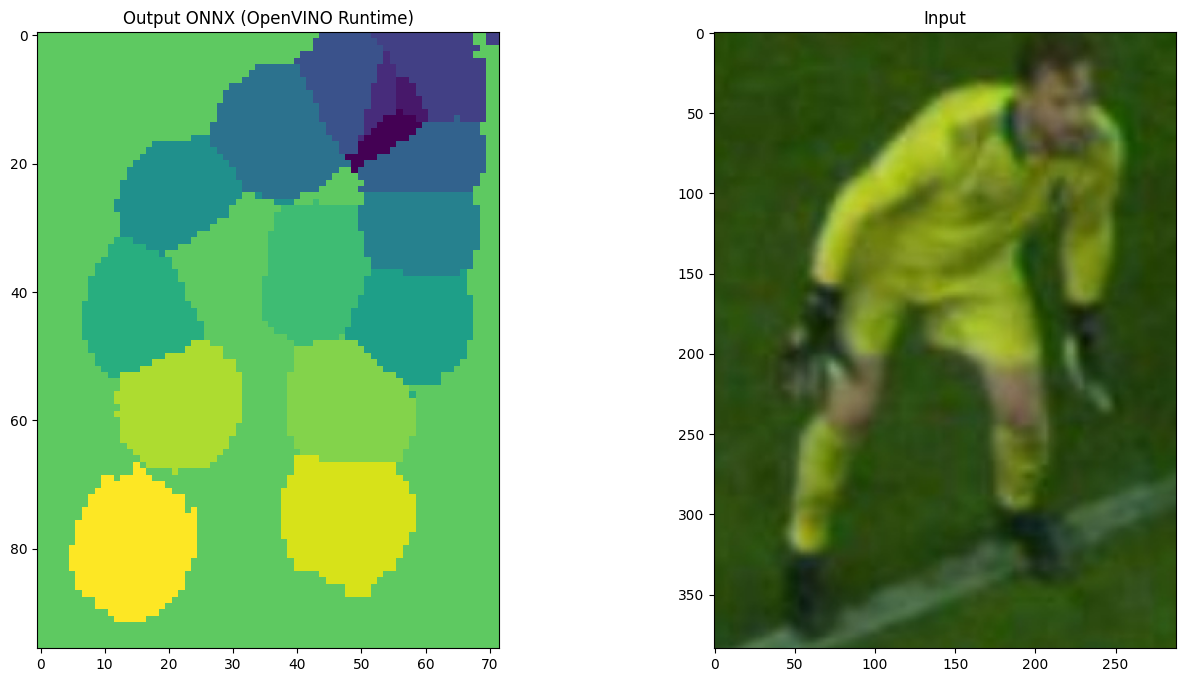

In [32]:
# Convert the network result to a segmentation map and display the result.
result_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
viz_result_image(image, result_onnx, source_title="Output ONNX (OpenVINO Runtime)", result_title="Input")

#### 2. OpenVINO IR Model in OpenVINO Runtime

In [13]:
# Load the network in OpenVINO Runtime
ie = Core()
model_ir = ie.read_model(model=ir_path)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers
output_layer_ir = compiled_model_ir.output(0)

# Run inference on the input image
res_ir = compiled_model_ir([input_image])[output_layer_ir]

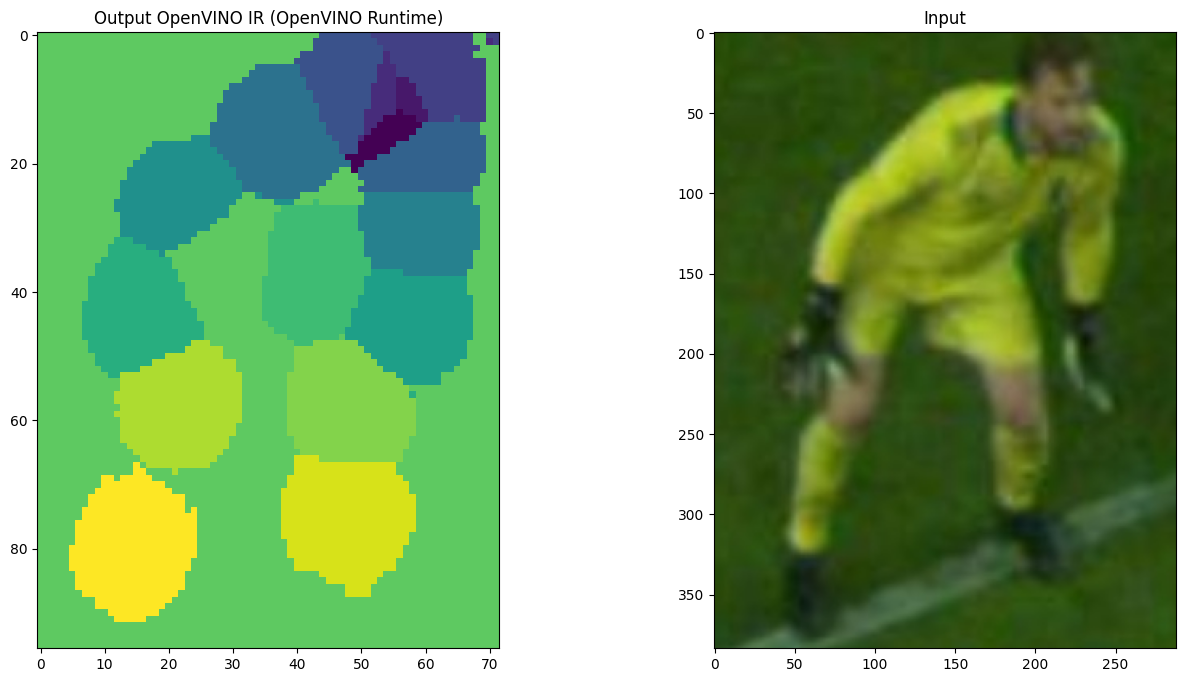

In [31]:
result_ir = np.squeeze(np.argmax(res_ir, axis=1)).astype(np.uint8)
viz_result_image(image, result_ir, source_title="Output OpenVINO IR (OpenVINO Runtime)", result_title="Input")

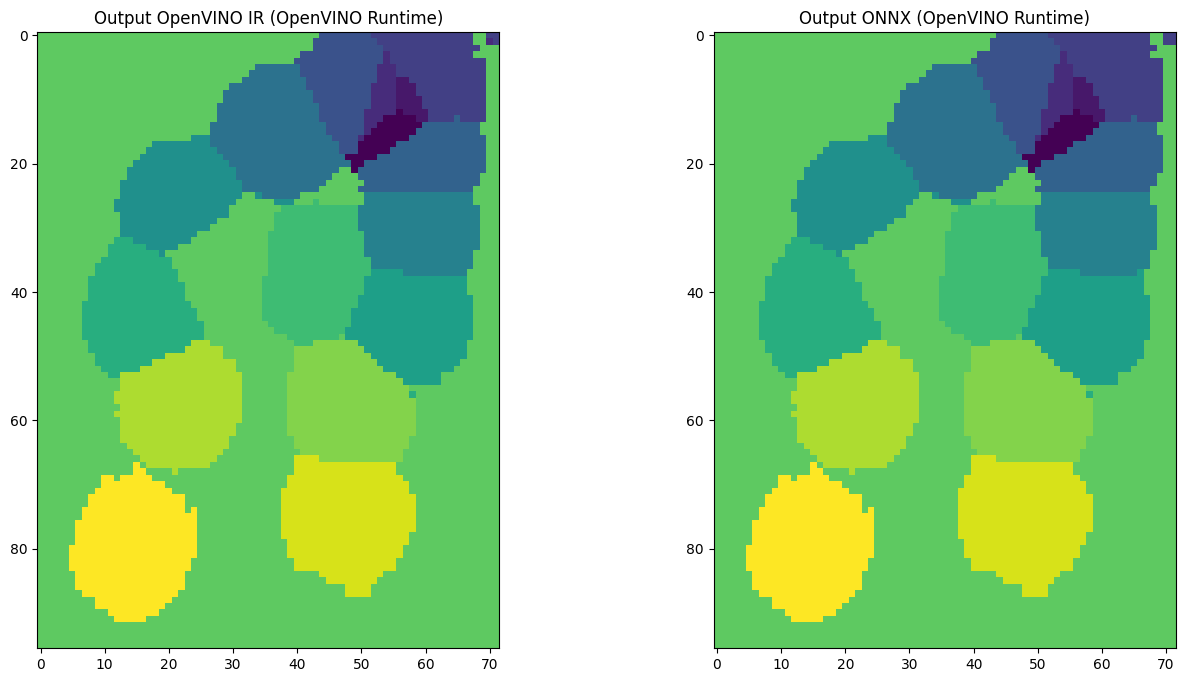

In [29]:
viz_result_image(result_onnx, result_ir, source_title="Output OpenVINO IR (OpenVINO Runtime)", result_title="Output ONNX (OpenVINO Runtime)")

## ONNX Comparison

Do inference on the ONNX model to verify that the output visually looks the same as the output on the ONNX/OpenVINO IR models.

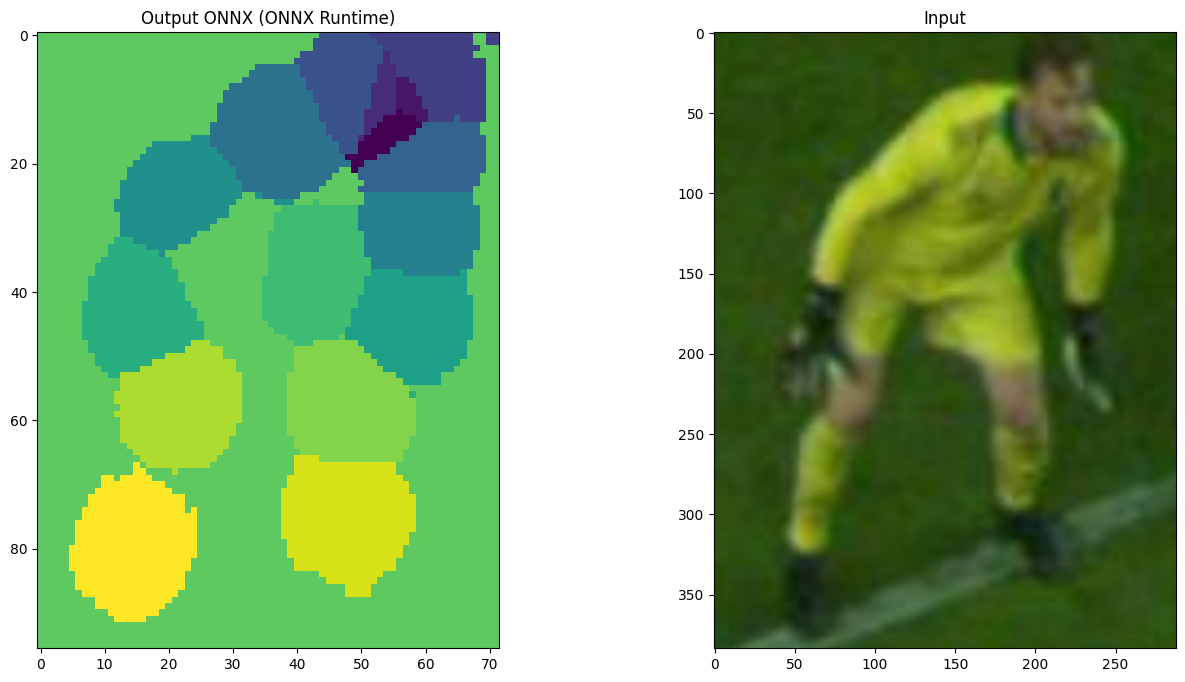

In [34]:
session = ort.InferenceSession('model/input.onnx', providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
(_, _, height, width) = session.get_inputs()[0].shape

ort_res = session.run([], {input_name: normalized_input_image})
result_ort = np.squeeze(np.argmax(ort_res, axis=2)).astype(np.uint8)
viz_result_image(image, result_ort, source_title="Output ONNX (ONNX Runtime)", result_title="Input")

## Performance Comparison

Measure the time it takes to do inference on twenty images. This gives an indication of performance. For more accurate benchmarking, use the [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html). Keep in mind that many other optimizations are possible to improve the performance. 

In [35]:
num_images = 20

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_onnx([normalized_input_image])
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in OpenVINO Runtime/CPU: {time_onnx/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

session = ort.InferenceSession('model/input.onnx', providers=['CPUExecutionProvider'])
input_name = session.get_inputs()[0].name
(_, _, height, width) = session.get_inputs()[0].shape

# Warming up
_ = session.run([], {input_name: normalized_input_image})
start = time.perf_counter()
for _ in range(num_images):
    _ = session.run([], {input_name: normalized_input_image})
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in ONNX Runtime/CPU: {time_onnx/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

session = ort.InferenceSession('model/input.onnx', providers=['CUDAExecutionProvider'])
input_name = session.get_inputs()[0].name
(_, _, height, width) = session.get_inputs()[0].shape

# Warming up
_ = session.run([], {input_name: normalized_input_image})
start = time.perf_counter()
for _ in range(num_images):
    _ = session.run([], {input_name: normalized_input_image})
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in ONNX Runtime/GPU: {time_onnx/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

start = time.perf_counter()
for _ in range(num_images):
    compiled_model_ir([input_image])
end = time.perf_counter()
time_ir = end - start
print(
    f"OpenVINO IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

if "GPU" in ie.available_devices:
    compiled_model_onnx_gpu = ie.compile_model(model=model_onnx, device_name="GPU")
    start = time.perf_counter()
    for _ in range(num_images):
        compiled_model_onnx_gpu([input_image])
    end = time.perf_counter()
    time_onnx_gpu = end - start
    print(
        f"ONNX model in OpenVINO/GPU: {time_onnx_gpu/num_images:.3f} "
        f"seconds per image, FPS: {num_images/time_onnx_gpu:.2f}"
    )

    compiled_model_ir_gpu = ie.compile_model(model=model_ir, device_name="GPU")
    start = time.perf_counter()
    for _ in range(num_images):
        compiled_model_ir_gpu([input_image])
    end = time.perf_counter()
    time_ir_gpu = end - start
    print(
        f"IR model in OpenVINO/GPU: {time_ir_gpu/num_images:.3f} "
        f"seconds per image, FPS: {num_images/time_ir_gpu:.2f}"
    )

ONNX model in OpenVINO Runtime/CPU: 0.121 seconds per image, FPS: 8.29
ONNX model in ONNX Runtime/CPU: 0.105 seconds per image, FPS: 9.50
ONNX model in ONNX Runtime/GPU: 0.031 seconds per image, FPS: 32.59
OpenVINO IR model in OpenVINO Runtime/CPU: 0.109 seconds per image, FPS: 9.15
